In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nbimporter
from HW5_Setup import two_dimensional_data
from normalizer import Normalizer

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    DTYPE = torch.float64
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    DTYPE = torch.float32
else:
    DEVICE = torch.device("cpu")
    DTYPE = torch.float64

# Data Generation

In [ ]:
def generate_datasets():
    seeds = [563, 567, 569]  # fixed seed for reproducibility
    sizes = [500, 1000, 5000]
    names = ["moons", "pinwheel", "swissroll"]

    datasets_dict = {}

    for i, name in enumerate(names):
        datasets_dict[name] = {}
        for N in sizes:
            rng = np.random.RandomState(seeds[i])  # same seed for each size
            data_np = two_dimensional_data(name, rng=rng, batch_size=N)
            data_tensor = torch.tensor(data_np, dtype=DTYPE, device=DEVICE)
            datasets_dict[name][N] = data_tensor

    return datasets_dict


def generate_references():
    seeds = [531, 568, 562]
    sizes = [500, 1000, 5000]

    datasets_list = []

    for i, size in enumerate(sizes):
        torch.manual_seed(seeds[i])
        datasets_list.append(torch.randn(size, 2, dtype=DTYPE, device=DEVICE))

    return datasets_list


targets, references = generate_datasets(), generate_references()
moons500, moons1k, moons5k = targets["moons"][500], targets["moons"][1000], targets["moons"][5000]
print(moons500.shape, moons1k.shape, moons5k.shape)
print(moons500.device, moons1k.device, moons5k.device)
print(moons500.dtype, moons1k.dtype, moons5k.dtype)
pinwheel500, pinwheel1k, pinwheel5k = targets["pinwheel"][500], targets["pinwheel"][1000], targets["pinwheel"][5000]
swissroll500, swissroll1k, swissroll5k = targets["swissroll"][500], targets["swissroll"][1000], targets["swissroll"][5000]
ref500, ref1k, ref5k = references
print(ref500.shape, ref1k.shape, ref5k.shape)
print(ref500.device, ref1k.device, ref5k.device)
print(ref500.dtype, ref1k.dtype, ref5k.dtype)

torch.Size([500, 2]) torch.Size([1000, 2]) torch.Size([5000, 2])
mps:0 mps:0 mps:0
torch.float32 torch.float32 torch.float32
torch.Size([500, 2]) torch.Size([1000, 2]) torch.Size([5000, 2])
mps:0 mps:0 mps:0
torch.float32 torch.float32 torch.float32


# Part 1

In [ ]:
# Kernels and MMD

def rbf(X, Y, length):
    dist_sq = torch.cdist(X, Y) ** 2
    return torch.exp(-dist_sq / (2 * (length ** 2)))

def lap(X, Y, length):
    dist = torch.cdist(X, Y, p=1)
    return torch.exp(-dist / length)

def poly(X, Y, coef0=1, degree=2):
    return (X @ Y.T + coef0) ** degree

def mmd_sq(X, Y, length=0.1, coef0=1, degree=2, kernel_func=rbf):
    N = X.shape[0]
    if kernel_func.__name__ in ['rbf', 'lap']:
        K_xx = kernel_func(X, X, length)
        K_yy = kernel_func(Y, Y, length)
        K_xy = kernel_func(X, Y, length)
    else:
        K_xx = kernel_func(X, X, coef0, degree)
        K_yy = kernel_func(Y, Y, coef0, degree)
        K_xy = kernel_func(X, Y, coef0, degree)
    mmd2 = (
        K_xx.sum() / (N * N)
        + K_yy.sum() / (N * N)
        - 2 * K_xy.sum() / (N * N)
    )
    return mmd2

def median_heuristic(X, Y):
    """
    X and Y should be normalized
    """
    with torch.no_grad():
        pairwise_dists = torch.cdist(X, Y)
        med = torch.median(pairwise_dists)
    return med

In [ ]:
# Part 1
N = 5000
d = 2
names = ['moons', 'pinwheel', 'swissroll']
mmd_table = pd.DataFrame(columns=[
    'Target', 'rbf', 'laplacian', '2nd-order poly'
])
ref_normalizer_5k = Normalizer()
ref_normalizer_5k.fit(ref5k)
ref5k_norm = ref_normalizer_5k.normalize(ref5k)
# print(ref5k_norm)

for name in names:
    tar_normalizer = Normalizer()
    target = targets[name][5000]
    tar_normalizer.fit(target)
    tar_norm = tar_normalizer.normalize(target)

    with torch.no_grad():
        diff = ref5k_norm[:, None, :] - tar_norm[None, :, :]   # shape [5000, 5000, 2]
        pairwise_dists = torch.norm(diff, dim=2)               # shape [5000, 5000]
        length = torch.median(pairwise_dists)
    print(length)
    coef0 = 1

    rbf_mmd2 = mmd_sq(ref5k_norm, tar_norm, length=length, kernel_func=rbf)
    lap_mmd2 = mmd_sq(ref5k_norm, tar_norm, length=length, kernel_func=lap)
    poly_mmd2 = mmd_sq(ref5k_norm, tar_norm, coef0=coef0, degree=d, kernel_func=poly)

    rbf_mmd = np.sqrt(rbf_mmd2.cpu().numpy())
    lap_mmd = np.sqrt(lap_mmd2.cpu().numpy())
    poly_mmd = np.sqrt(poly_mmd2.cpu().numpy())

    mmd_table.loc[len(mmd_table)] = [
        name, rbf_mmd, lap_mmd, poly_mmd
    ]

print(mmd_table)

tensor(1.7247, device='mps:0')
tensor(1.7284, device='mps:0')
tensor(1.7218, device='mps:0')
      Target       rbf  laplacian  2nd-order poly
0      moons  0.099921   0.135966        0.594654
1   pinwheel  0.039885   0.123008        0.054987
2  swissroll  0.047850   0.108020        0.167911


# Part 2 and 3

In [ ]:
# Trainer and CrossValidator
# param_dict = [lambda, length/coef0, degree]
def transport(kernel_func, X, alpha, param_dict):
    """
    Return the built K(X, X) as well
    """
    if kernel_func.__name__ in ['rbf', 'lap']:
        ker_mat = kernel_func(X, X, param_dict['bandwidth'])
    else:
        ker_mat = kernel_func(X, X, param_dict['coef0'], param_dict['degree'])
    transported = ker_mat @ alpha + X
    return ker_mat, transported

def reg_norm(ker_mat, stabler, alpha):
    n = ker_mat.shape[0]
    mat_reg = ker_mat + stabler * torch.eye(n, device=DEVICE)
    sol = torch.linalg.solve(mat_reg.cpu(), alpha.cpu())
    return torch.sum(sol.to(DEVICE) * alpha.to(DEVICE))

def train(X, Y, kernel_func, param_dict,
          mmd_len=0.3, lr=1e-2, num_steps=500, verbose=False):
    n, d = X.shape
    alpha = torch.nn.Parameter(torch.randn(n, d, device=DEVICE)* 0.01)
    lam = param_dict['lambda']
    if kernel_func.__name__ == 'poly' and param_dict['degree'] == 4:
        stabler = 1e-1
    elif kernel_func.__name__ == 'poly':
        stabler = 1e-2
    else:
        stabler = 1e-4

    loss_list = []

    opt = torch.optim.Adam([alpha], lr=lr)
    for step in range(num_steps):
        opt.zero_grad()
        T_mat, T_x = transport(kernel_func, X, alpha, param_dict)
        mmd_loss = mmd_sq(T_x, Y, mmd_len)
        reg = reg_norm(T_mat, stabler, alpha)
        loss = mmd_loss + (lam / 2) * reg
        loss_list.append(loss)

        loss.backward()
        opt.step()

        if verbose and step % 100 == 0:
            print(f'[{step}]MMD²: {mmd_loss.item():.6f} | RKHS norm: {reg.item():.4f}')
    return loss_list, transport(kernel_func, X, alpha, param_dict) #.detach()


def train_quasinewton(X, Y, kernel_func, param_dict,
          mmd_len=0.3, lr=1.0, num_steps=50, verbose=False):
    n, d = X.shape
    alpha = torch.nn.Parameter(torch.randn(n, d, device=DEVICE) * 0.01)
    lam = param_dict['lambda']

    opt = torch.optim.LBFGS([alpha], lr=lr, max_iter=num_steps, line_search_fn="strong_wolfe")

    def closure():
        opt.zero_grad()
        T_mat, T_x = transport(kernel_func, X, alpha, param_dict)
        mmd_loss = mmd_sq(T_x, Y, mmd_len)
        reg = reg_norm(T_mat, 1e-4, alpha)
        loss = mmd_loss + (lam / 2) * reg
        loss.backward()

        if verbose:
            print(f'MMD²: {mmd_loss.item():.6f} | RKHS norm: {reg.item():.4f}')
        return loss

    opt.step(closure)

    # Recompute final transport after optimization
    with torch.no_grad():
        _, T_x_final = transport(kernel_func, X, alpha, param_dict)
    return _, T_x_final



def sample_lambda(low, high):
    log_low = torch.log10(torch.tensor(low, dtype=DTYPE, device=DEVICE))
    log_high = torch.log10(torch.tensor(high, dtype=DTYPE, device=DEVICE))
    log_sample = torch.empty(1, device=DEVICE, dtype=DTYPE).uniform_(log_low, log_high)
    return 10 ** log_sample.item()

def sample_param_dict(param_dict):
    sampled = {}
    for key, bounds in param_dict.items():
        low, high = bounds
        if key == "degree":
            sampled[key] = int(torch.randint(low, high + 1, (1,), device=DEVICE).item())
        elif key == 'lambda':
            sampled[key] = sample_lambda(bounds[0], bounds[1])
        else:
            sampled[key] = torch.empty(1, device=DEVICE, dtype=torch.float32).uniform_(low, high).item()
    return sampled


def tuner(X, Y, param_dict, kernel_func, mmd_len=0.3, lr=1e-2, n_trials=10, num_steps=20, verbose=False):
    best_config = None
    best_score = float('inf')
    best_transport = None
    loss_list = None

    for trial in range(n_trials):
        params = sample_param_dict(param_dict)
        score = 0

        cur_loss_list, (_, transported) = train(X, Y, kernel_func, params, mmd_len, lr, num_steps, verbose)
        score = mmd_sq(transported, Y, mmd_len)
        print(f'[Trial {trial+1}/{n_trials}] params={params} → MMD²: {score:.6f}')

        if score < best_score:
            best_score = score
            best_config = params
            best_transport = transported
            loss_list = cur_loss_list

    print(f"Best config: {params} | MMD²={best_score:.6f}")
    return best_config, best_transport.detach(), best_score, loss_list

In [ ]:
def one_model_output(references, targets, trans_kernel, param_dict,
                     verbose=False, n_trials=5, beta=0.3, num_steps=20, lr=1e-2):
    ref_normer = Normalizer()
    tar_normer = Normalizer()
    ref_normer.fit(references)
    tar_normer.fit(targets)
    ref_norm = ref_normer.normalize(references)
    tar_norm = tar_normer.normalize(targets)

    mmd_length = beta * median_heuristic(ref_norm, tar_norm)
    _, best_transport, best_score, loss_list = tuner(ref_norm, tar_norm, param_dict, trans_kernel,
                                        verbose=verbose, n_trials=n_trials, mmd_len=mmd_length,
                                        num_steps=num_steps, lr=lr)
    best_gen = tar_normer.denormalize(best_transport)

    return best_gen, best_score, loss_list


def heat_map(ref_tran, trans_kernel='rbf', std_coef=0.5):
    ref_tran = ref_tran.cpu().numpy()

    x1_median = np.median(ref_tran[:, 0])
    x2_median = np.median(ref_tran[:, 1])
    x1_std = np.std(ref_tran[:, 0])
    x2_std = np.std(ref_tran[:, 1])
    if trans_kernel in ['poly1', 'poly2', 'poly4']:
        plot_range = [
            [x1_median - std_coef * x1_std, x1_median + std_coef * x1_std],
            [x2_median - std_coef * x2_std, x2_median + std_coef * x2_std]
        ]
    else:
        plot_range = [[-4, 4], [-4, 4]]

    plt.figure(figsize=(8, 6))
    plt.hist2d(ref_tran[:, 0], ref_tran[:, 1], bins=100,
               cmap='inferno', density=True, range=plot_range,)
    plt.colorbar(label='Density')
    plt.title(f'Heatmap of Dataset, {trans_kernel}')
    plt.xlabel('x_1')
    plt.ylabel('x_2')

[Trial 1/5] params={'lambda': 0.006253336829441485, 'bandwidth': 0.454145610332489} → MMD²: 0.000856
[Trial 2/5] params={'lambda': 0.0059493578311670915, 'bandwidth': 0.6511633992195129} → MMD²: 0.000868
[Trial 3/5] params={'lambda': 0.0010401398874722706, 'bandwidth': 0.5345296263694763} → MMD²: 0.004824
[Trial 4/5] params={'lambda': 0.00023099033928218894, 'bandwidth': 0.7066143155097961} → MMD²: 0.020631
[Trial 5/5] params={'lambda': 0.001127000811258847, 'bandwidth': 0.6860288381576538} → MMD²: 0.008982
Best config: {'lambda': 0.001127000811258847, 'bandwidth': 0.6860288381576538} | MMD²=0.000856


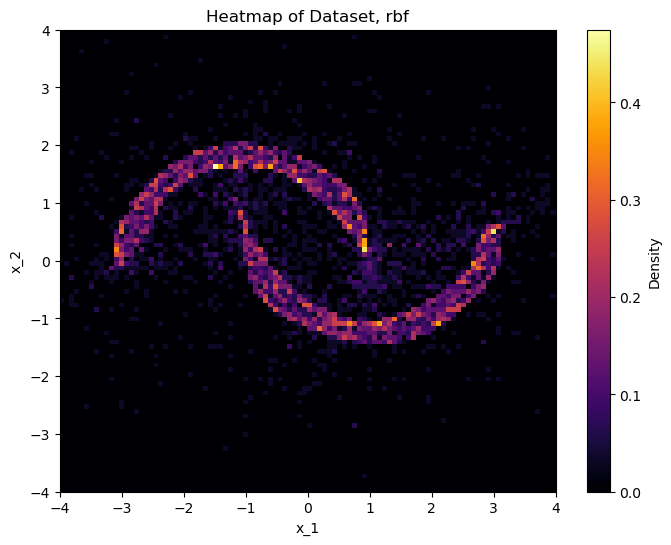

In [ ]:
param_dict = {
    'lambda': [1e-4, 1e-2],
    'bandwidth': [1e-1, 8e-1]
}
best_gen_rbfmoon, best_score_rbf_moon, best_loss_rbfmoon = one_model_output(ref5k, moons5k, rbf, param_dict,
                                          verbose=False, n_trials=5, beta=0.1, num_steps=500)
heat_map(best_gen_rbfmoon, 'rbf')

[Trial 1/5] params={'lambda': 0.006484984767948162, 'bandwidth': 0.5002979636192322} → MMD²: 0.001761
[Trial 2/5] params={'lambda': 0.0004990257754830234, 'bandwidth': 0.8026071786880493} → MMD²: 0.007252
[Trial 3/5] params={'lambda': 0.0006100304517142341, 'bandwidth': 0.7451283931732178} → MMD²: 0.011550
[Trial 4/5] params={'lambda': 0.005867345697151575, 'bandwidth': 0.4999208152294159} → MMD²: 0.002836
[Trial 5/5] params={'lambda': 0.004152414284301663, 'bandwidth': 0.8731297850608826} → MMD²: 0.035906
Best config: {'lambda': 0.004152414284301663, 'bandwidth': 0.8731297850608826} | MMD²=0.001761


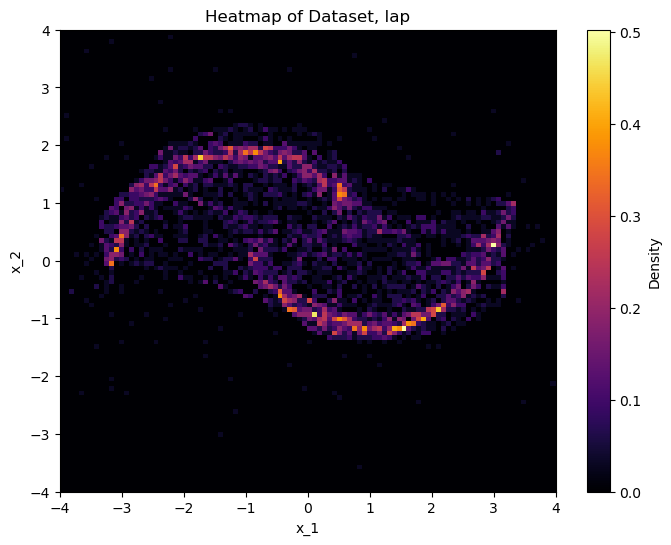

In [ ]:
param_dict = {
    'lambda': [1e-4, 1e-2],
    'bandwidth': [4e-1, 9e-1]
}
best_gen_lapmoon, best_score_lapmoon, best_loss_lapmoon = one_model_output(ref5k, moons5k,
                                                                           lap, param_dict, verbose=False, n_trials=5, beta=0.3, num_steps=500)
heat_map(best_gen_lapmoon, 'lap')

# the bandwidth [1e-1, 1e0] broke the nice result, let's narrow it down to [1e-1, 8e-1]

[0]MMD²: 0.321397 | RKHS norm: 99.6877
[100]MMD²: 0.271749 | RKHS norm: 0.1780
[200]MMD²: 0.271124 | RKHS norm: 0.0008
[300]MMD²: 0.270781 | RKHS norm: 0.0004
[400]MMD²: 0.270570 | RKHS norm: 0.0002
[Trial 1/5] params={'lambda': 0.015687858879569118, 'coef0': 2.4272706508636475, 'degree': 1} → MMD²: 0.270309
[0]MMD²: 0.447857 | RKHS norm: 98.1272
[100]MMD²: 0.270892 | RKHS norm: 0.0038
[200]MMD²: 0.270542 | RKHS norm: 0.0002
[300]MMD²: 0.270315 | RKHS norm: 0.0001
[400]MMD²: 0.270161 | RKHS norm: 0.0001
[Trial 2/5] params={'lambda': 0.01632103936512533, 'coef0': 2.3022608757019043, 'degree': 1} → MMD²: 0.270052
[0]MMD²: 0.130677 | RKHS norm: 101.6288
[100]MMD²: 0.270312 | RKHS norm: 108.3725
[200]MMD²: 0.270228 | RKHS norm: 102.6153
[300]MMD²: 0.269971 | RKHS norm: 96.3233
[400]MMD²: 0.269943 | RKHS norm: 90.0242
[Trial 3/5] params={'lambda': 1.3935424938584157e-05, 'coef0': 2.020750045776367, 'degree': 1} → MMD²: 0.269915
[0]MMD²: 0.056575 | RKHS norm: 99.5381
[100]MMD²: 0.256436 | RK

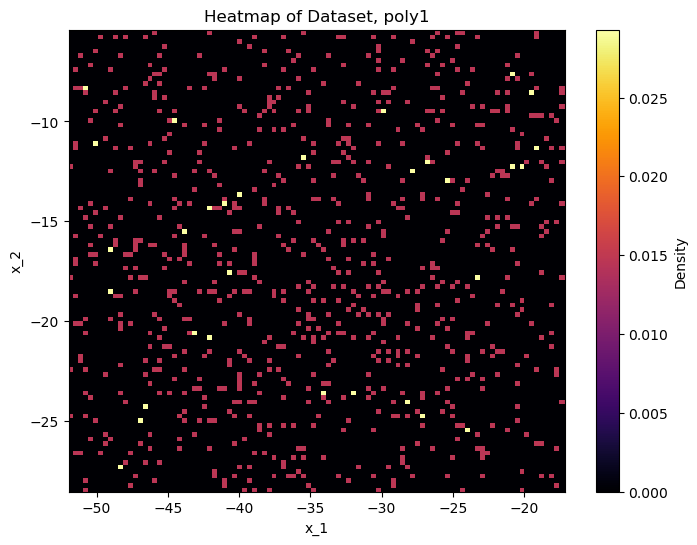

In [ ]:
param_dict = {
    'lambda': [1e-7, 1e0],
    'coef0': [1, 3],
    'degree': [1,1]
}
best_gen_poly1moon, best_score_poly1moon, best_loss_poly1moon = one_model_output(ref5k, moons5k, poly, param_dict,
                                      verbose=True, n_trials=5, beta=0.5, lr=1e-3, num_steps=500)
heat_map(best_gen_poly1moon, 'poly1')

[0]MMD²: 0.203900 | RKHS norm: 99.9819
[100]MMD²: 0.252941 | RKHS norm: 12.5430
[200]MMD²: 0.252863 | RKHS norm: 1.3547
[300]MMD²: 0.252737 | RKHS norm: 0.1349
[400]MMD²: 0.252623 | RKHS norm: 0.0139
[Trial 1/5] params={'lambda': 0.002769329973650167, 'coef0': 1.705256462097168, 'degree': 1} → MMD²: 0.252528
[0]MMD²: 0.144303 | RKHS norm: 97.8443
[100]MMD²: 0.250528 | RKHS norm: 108.6545
[200]MMD²: 0.250475 | RKHS norm: 107.7146
[300]MMD²: 0.250393 | RKHS norm: 106.4417
[400]MMD²: 0.250261 | RKHS norm: 104.8411
[Trial 2/5] params={'lambda': 1.0173516284699282e-06, 'coef0': 1.553954839706421, 'degree': 1} → MMD²: 0.250022
[0]MMD²: 0.215154 | RKHS norm: 100.2752
[100]MMD²: 0.253274 | RKHS norm: 98.3192
[200]MMD²: 0.253062 | RKHS norm: 91.9836
[300]MMD²: 0.252890 | RKHS norm: 84.2219
[400]MMD²: 0.252757 | RKHS norm: 75.7127
[Trial 3/5] params={'lambda': 8.783544299553278e-05, 'coef0': 2.5928125381469727, 'degree': 1} → MMD²: 0.252653
[0]MMD²: 0.085870 | RKHS norm: 100.4774
[100]MMD²: 0.22

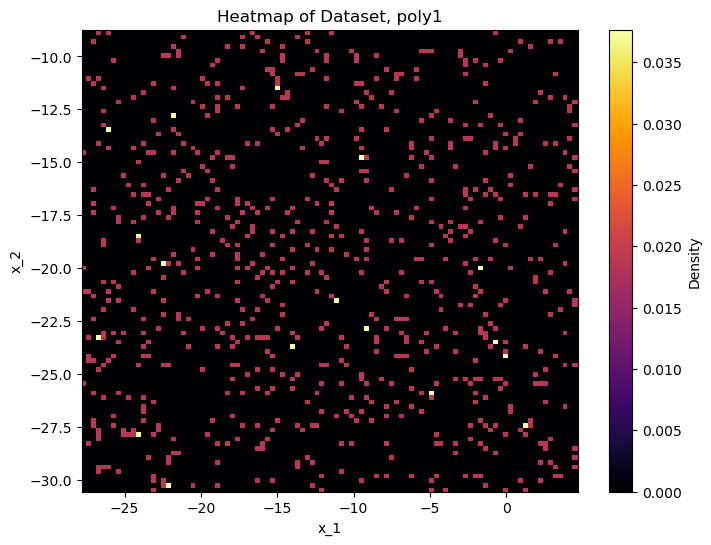

In [ ]:
param_dict = {
    'lambda': [1e-7, 1e0],
    'coef0': [1, 3],
    'degree': [1,1]
}
best_gen_poly1pin, best_score_poly1pin, best_loss_poly1pin = one_model_output(ref5k, pinwheel5k, poly, param_dict,
                                      verbose=True, n_trials=5, beta=0.5, lr=1e-3, num_steps=500)
heat_map(best_gen_poly1pin, 'poly1')

[0]MMD²: 0.119395 | RKHS norm: 99.7649
[100]MMD²: 0.252303 | RKHS norm: 108.0445
[200]MMD²: 0.252265 | RKHS norm: 108.4123
[300]MMD²: 0.252223 | RKHS norm: 108.8601
[400]MMD²: 0.252184 | RKHS norm: 109.3518
[Trial 1/5] params={'lambda': 1.2968059209399915e-07, 'coef0': 1.6515812873840332, 'degree': 1} → MMD²: 0.252147
[0]MMD²: 0.132723 | RKHS norm: 98.4345
[100]MMD²: 0.253296 | RKHS norm: 98.6575
[200]MMD²: 0.252987 | RKHS norm: 98.1900
[300]MMD²: 0.252787 | RKHS norm: 97.5423
[400]MMD²: 0.252653 | RKHS norm: 96.7367
[Trial 2/5] params={'lambda': 3.7798709989431674e-06, 'coef0': 2.720322370529175, 'degree': 1} → MMD²: 0.252557
[0]MMD²: 0.188047 | RKHS norm: 102.4617
[100]MMD²: 0.009049 | RKHS norm: 0.0015
[200]MMD²: 0.008798 | RKHS norm: 0.0000
[300]MMD²: 0.009593 | RKHS norm: 0.0000
[400]MMD²: 0.222912 | RKHS norm: 0.0049
[Trial 3/5] params={'lambda': 0.29691681435743905, 'coef0': 1.1161091327667236, 'degree': 1} → MMD²: 0.208637
[0]MMD²: 0.379487 | RKHS norm: 100.9503
[100]MMD²: 0.01

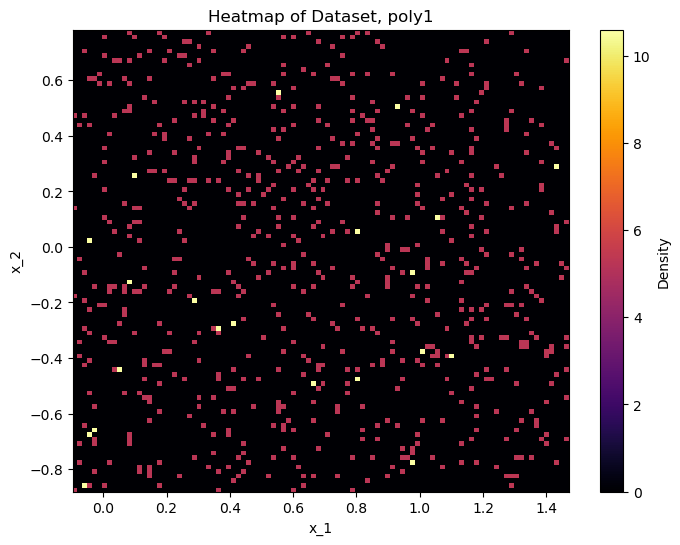

In [ ]:
param_dict = {
    'lambda': [1e-7, 1e0],
    'coef0': [1, 3],
    'degree': [1,1]
}
best_gen_poly1swiss, best_score_poly1swiss, best_loss_poly1swiss = one_model_output(ref5k, swissroll5k, poly, param_dict,
                                      verbose=True, n_trials=5, beta=0.5, lr=1e-3, num_steps=500)
heat_map(best_gen_poly1swiss, 'poly1')

[0]MMD²: 0.078743 | RKHS norm: 99.3367
[100]MMD²: 0.076468 | RKHS norm: 0.0023
[200]MMD²: 0.049198 | RKHS norm: 0.0023
[300]MMD²: 0.221829 | RKHS norm: 0.0025
[400]MMD²: 0.068941 | RKHS norm: 0.0039
[Trial 1/5] params={'lambda': 9.503797349023541, 'coef0': 0.8638566136360168, 'degree': 2} → MMD²: 0.095402
[0]MMD²: 0.109506 | RKHS norm: 101.8423
[100]MMD²: 0.088816 | RKHS norm: 0.0059
[200]MMD²: 0.046225 | RKHS norm: 0.0007
[300]MMD²: 0.146409 | RKHS norm: 0.0061
[400]MMD²: 0.148002 | RKHS norm: 0.0051
[Trial 2/5] params={'lambda': 5.860115677186592, 'coef0': 0.8673675060272217, 'degree': 2} → MMD²: 0.270559
[0]MMD²: 0.123403 | RKHS norm: 100.0233
[100]MMD²: 0.228354 | RKHS norm: 0.0021
[200]MMD²: 0.235699 | RKHS norm: 0.0008
[300]MMD²: 0.271339 | RKHS norm: 0.0004
[400]MMD²: 0.270977 | RKHS norm: 0.0000
[Trial 3/5] params={'lambda': 4.878949902894605, 'coef0': 0.9943094253540039, 'degree': 2} → MMD²: 0.270818
[0]MMD²: 0.107359 | RKHS norm: 99.9473
[100]MMD²: 0.269892 | RKHS norm: 0.001

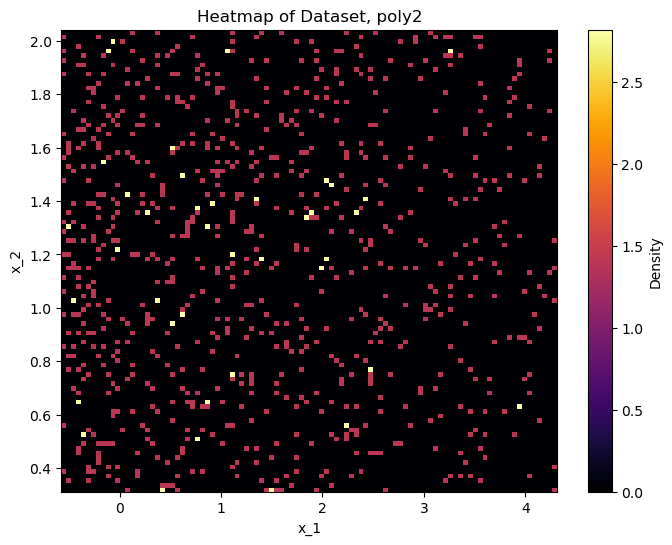

In [ ]:
param_dict = {
    'lambda': [1e-3, 1e1],
    'coef0': [1e-1, 1],
    'degree': [2,2]
}
best_gen_poly2moon, best_score_poly2moon, best_loss_poly2moon = one_model_output(ref5k, moons5k, poly,
                                      param_dict, verbose=True, n_trials=5, beta=0.5, num_steps=500, lr=1e-2)
heat_map(best_gen_poly2moon, 'poly2')

[0]MMD²: 0.085229 | RKHS norm: 101.4626
[100]MMD²: 0.251873 | RKHS norm: 0.0232
[200]MMD²: 0.251873 | RKHS norm: 0.0147
[300]MMD²: 0.251873 | RKHS norm: 0.0147
[400]MMD²: 0.251873 | RKHS norm: 0.0147
[Trial 1/5] params={'lambda': 0.0011544523771476018, 'coef0': 0.520747184753418, 'degree': 2} → MMD²: 0.251873
[0]MMD²: 0.133995 | RKHS norm: 98.9086
[100]MMD²: 0.252602 | RKHS norm: 0.0015
[200]MMD²: 0.252440 | RKHS norm: 0.0001
[300]MMD²: 0.252340 | RKHS norm: 0.0001
[400]MMD²: 0.252273 | RKHS norm: 0.0001
[Trial 2/5] params={'lambda': 0.17516748826854922, 'coef0': 0.4238896071910858, 'degree': 2} → MMD²: 0.252225
[0]MMD²: 0.126557 | RKHS norm: 98.1776
[100]MMD²: 0.252076 | RKHS norm: 0.3766
[200]MMD²: 0.252030 | RKHS norm: 0.3499
[300]MMD²: 0.252005 | RKHS norm: 0.3194
[400]MMD²: 0.251989 | RKHS norm: 0.2863
[Trial 3/5] params={'lambda': 0.0031851575039576543, 'coef0': 0.12374130636453629, 'degree': 2} → MMD²: 0.251978
[0]MMD²: 0.146306 | RKHS norm: 98.3100
[100]MMD²: 0.251935 | RKHS no

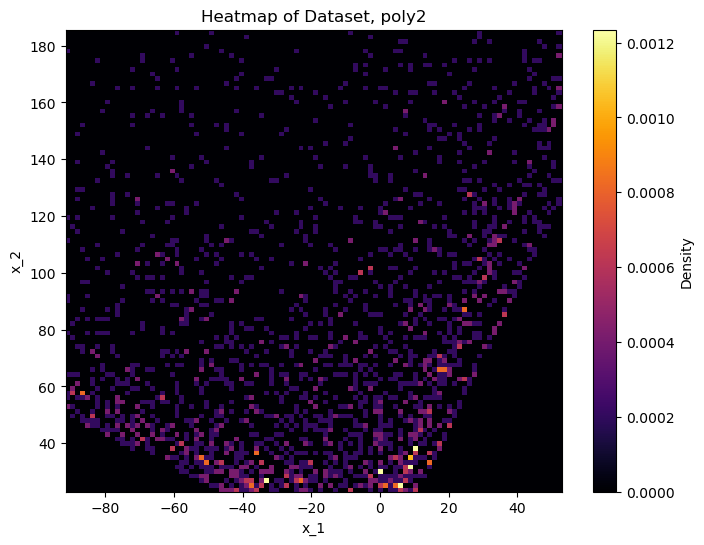

In [ ]:
param_dict = {
    'lambda': [1e-3, 1e1],
    'coef0': [1e-1, 1],
    'degree': [2,2]
}
best_gen_poly2pin, best_score_poly2pin, best_loss_poly2pin = one_model_output(ref5k, pinwheel5k, poly,
                                      param_dict, verbose=True, n_trials=5, beta=0.5, num_steps=500, lr=1e-2)
heat_map(best_gen_poly2pin, 'poly2')

# TODO：find the median, max, min, and std of these polynomial transport points

[0]MMD²: 0.129968 | RKHS norm: 99.7137
[100]MMD²: 0.252000 | RKHS norm: 0.0039
[200]MMD²: 0.252000 | RKHS norm: 0.0021
[300]MMD²: 0.252000 | RKHS norm: 0.0020
[400]MMD²: 0.251999 | RKHS norm: 0.0022
[Trial 1/5] params={'lambda': 0.02270477740761121, 'coef0': 0.9028107523918152, 'degree': 2} → MMD²: 0.251999
[0]MMD²: 0.160040 | RKHS norm: 100.5834
[100]MMD²: 0.251982 | RKHS norm: 0.0109
[200]MMD²: 0.251981 | RKHS norm: 0.0083
[300]MMD²: 0.251981 | RKHS norm: 0.0083
[400]MMD²: 0.251980 | RKHS norm: 0.0083
[Trial 2/5] params={'lambda': 0.006558203048081445, 'coef0': 0.8075700402259827, 'degree': 2} → MMD²: 0.251980
[0]MMD²: 0.125890 | RKHS norm: 99.2299
[100]MMD²: 0.252074 | RKHS norm: 2.4232
[200]MMD²: 0.252051 | RKHS norm: 0.1634
[300]MMD²: 0.252036 | RKHS norm: 0.0413
[400]MMD²: 0.252026 | RKHS norm: 0.0294
[Trial 3/5] params={'lambda': 0.0001654964276998927, 'coef0': 0.5274760723114014, 'degree': 2} → MMD²: 0.252019
[0]MMD²: 0.051615 | RKHS norm: 101.4506
[100]MMD²: 0.252094 | RKHS no

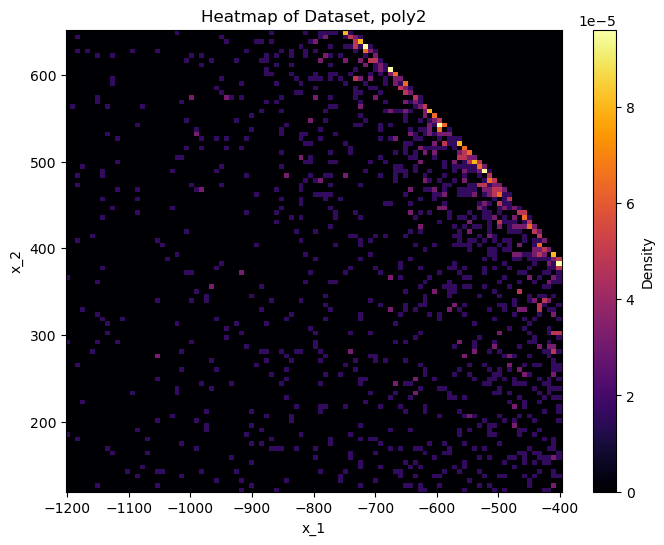

In [ ]:
param_dict = {
    'lambda': [1e-7, 1e0],
    'coef0': [1e-1, 1],
    'degree': [2,2]
}
best_gen_poly2swiss, best_score_poly2swiss, best_loss_poly2swiss = one_model_output(ref5k, swissroll5k, poly,
                                      param_dict, verbose=True, n_trials=5, beta=0.5, num_steps=500, lr=1e-2)
heat_map(best_gen_poly2swiss, 'poly2')

[0]MMD²: 0.204051 | RKHS norm: 10.0632
[100]MMD²: 0.269578 | RKHS norm: 38.7283
[200]MMD²: 0.269577 | RKHS norm: 3.7892
[300]MMD²: 0.269578 | RKHS norm: 1.2880
[400]MMD²: 0.269579 | RKHS norm: 1.0088
[Trial 1/5] params={'lambda': 5.245491252724152e-05, 'coef0': 0.7196140289306641, 'degree': 4} → MMD²: 0.269579
[0]MMD²: 0.237889 | RKHS norm: 10.0548
[100]MMD²: 0.269575 | RKHS norm: 0.3099
[200]MMD²: 0.269575 | RKHS norm: 0.2959
[300]MMD²: 0.269572 | RKHS norm: 0.2851
[400]MMD²: 0.269575 | RKHS norm: 0.2731
[Trial 2/5] params={'lambda': 0.007260430807223149, 'coef0': 1.0781140327453613, 'degree': 4} → MMD²: 0.269574
[0]MMD²: 0.247388 | RKHS norm: 10.0559
[100]MMD²: 0.269588 | RKHS norm: 0.0104
[200]MMD²: 0.269589 | RKHS norm: 0.0001
[300]MMD²: 0.269589 | RKHS norm: 0.0036
[400]MMD²: 0.269589 | RKHS norm: 0.0031
[Trial 3/5] params={'lambda': 0.2876246247430515, 'coef0': 0.9589987993240356, 'degree': 4} → MMD²: 0.269588
[0]MMD²: 0.234398 | RKHS norm: 9.9735
[100]MMD²: 0.269574 | RKHS norm:

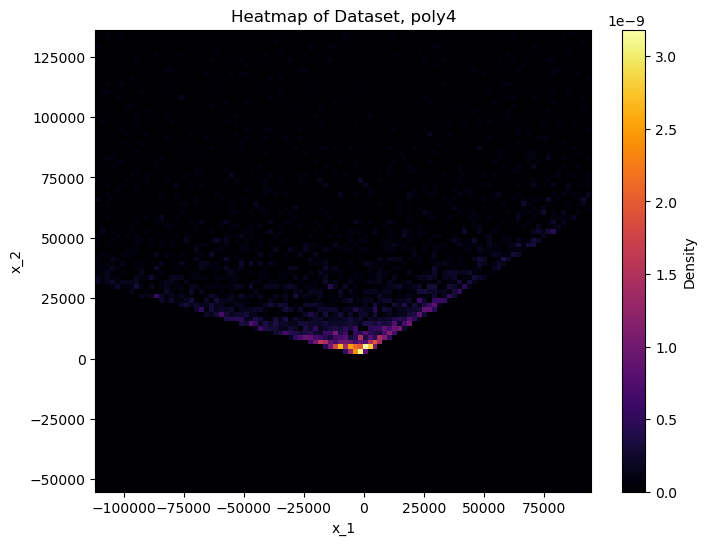

In [ ]:
param_dict = {
    'lambda': [1e-7, 1e0],
    'coef0': [5e-1, 1.5],
    'degree': [4,4]
}
best_gen_poly4moon, best_score_poly4moon, best_loss_poly4moon = one_model_output(ref5k, moons5k, poly, param_dict,
                                      verbose=True, n_trials=5, beta=0.5, num_steps=500, lr=1e-1)
heat_map(best_gen_poly4moon, 'poly4')

[0]MMD²: 0.224412 | RKHS norm: 10.0994
[100]MMD²: 0.251823 | RKHS norm: 0.0577
[200]MMD²: 0.251821 | RKHS norm: 0.1112
[300]MMD²: 0.251821 | RKHS norm: 0.0951
[400]MMD²: 0.251821 | RKHS norm: 0.1014
[Trial 1/5] params={'lambda': 0.11681120338033109, 'coef0': 1.1067527532577515, 'degree': 4} → MMD²: 0.251823
[0]MMD²: 0.224047 | RKHS norm: 9.7910
[100]MMD²: 0.251822 | RKHS norm: 0.3195
[200]MMD²: 0.251821 | RKHS norm: 0.3047
[300]MMD²: 0.251822 | RKHS norm: 0.2933
[400]MMD²: 0.251823 | RKHS norm: 0.2802
[Trial 2/5] params={'lambda': 0.002973433683773879, 'coef0': 1.0754755735397339, 'degree': 4} → MMD²: 0.251822
[0]MMD²: 0.252964 | RKHS norm: 10.0381
[100]MMD²: 0.251820 | RKHS norm: 0.1025
[200]MMD²: 0.251822 | RKHS norm: 0.0687
[300]MMD²: 0.251821 | RKHS norm: 0.0686
[400]MMD²: 0.251821 | RKHS norm: 0.0685
[Trial 3/5] params={'lambda': 3.8708192035314445e-05, 'coef0': 1.372859001159668, 'degree': 4} → MMD²: 0.251821
[0]MMD²: 0.248948 | RKHS norm: 10.0797
[100]MMD²: 0.251820 | RKHS norm:

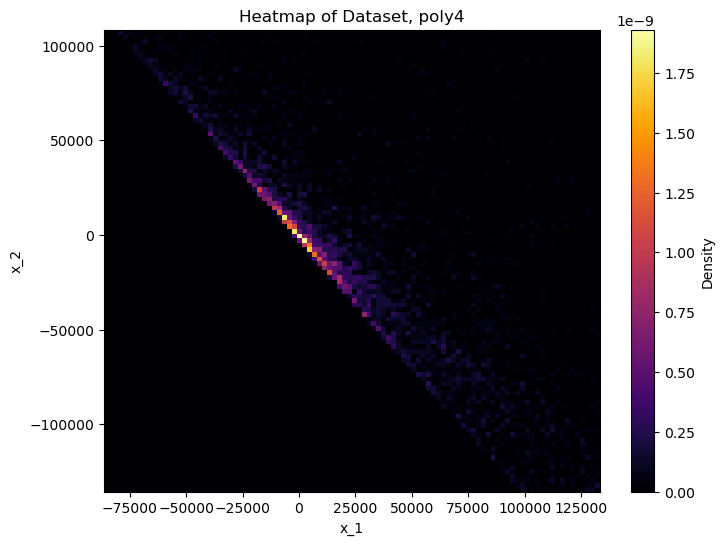

In [ ]:
param_dict = {
    'lambda': [1e-7, 1e0],
    'coef0': [5e-1, 1.5],
    'degree': [4,4]
}
best_gen_poly4pin, best_score_poly4pin, best_loss_poly4pin = one_model_output(ref5k, pinwheel5k, poly, param_dict,
                                      verbose=True, n_trials=5, beta=0.5, num_steps=500, lr=1e-1)
heat_map(best_gen_poly4pin, 'poly4')

[0]MMD²: 0.247629 | RKHS norm: 10.0207
[100]MMD²: 0.251951 | RKHS norm: 23.5963
[200]MMD²: 0.251951 | RKHS norm: 19.9768
[300]MMD²: 0.251950 | RKHS norm: 16.4764
[400]MMD²: 0.251948 | RKHS norm: 13.5795
[Trial 1/5] params={'lambda': 3.1861543532470403e-07, 'coef0': 1.4642205238342285, 'degree': 4} → MMD²: 0.251954
[0]MMD²: 0.192504 | RKHS norm: 9.9905
[100]MMD²: 0.251938 | RKHS norm: 23.6166
[200]MMD²: 0.251938 | RKHS norm: 1.6804
[300]MMD²: 0.251938 | RKHS norm: 0.7365
[400]MMD²: 0.251938 | RKHS norm: 0.5977
[Trial 2/5] params={'lambda': 7.965248708036147e-05, 'coef0': 0.8218483924865723, 'degree': 4} → MMD²: 0.251939
[0]MMD²: 0.226826 | RKHS norm: 9.9756
[100]MMD²: 0.251945 | RKHS norm: 0.0113
[200]MMD²: 0.251945 | RKHS norm: 0.0077
[300]MMD²: 0.251946 | RKHS norm: 0.0187
[400]MMD²: 0.251945 | RKHS norm: 0.0334
[Trial 3/5] params={'lambda': 0.9840878865150094, 'coef0': 1.2712684869766235, 'degree': 4} → MMD²: 0.251945
[0]MMD²: 0.238750 | RKHS norm: 9.8837
[100]MMD²: 0.251935 | RKHS n

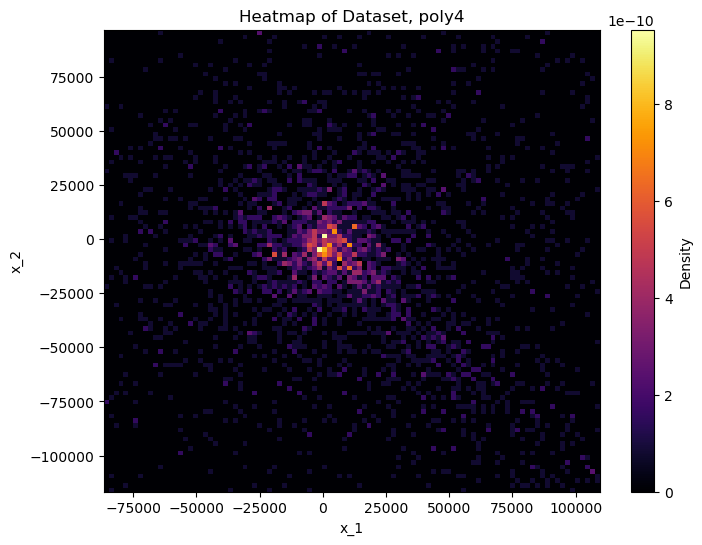

In [ ]:
param_dict = {
    'lambda': [1e-7, 1e0],
    'coef0': [5e-1, 1.5],
    'degree': [4,4]
}
best_gen_poly4swiss, best_score_poly4swiss, best_loss_poly4swiss = one_model_output(ref5k, swissroll5k, poly, param_dict,
                                      verbose=True, n_trials=5, beta=0.5, num_steps=500, lr=1e-1)
heat_map(best_gen_poly4swiss, 'poly4')

[Trial 1/5] params={'lambda': 1.5473142784287136e-05, 'bandwidth': 0.1310863345861435} → MMD²: 0.000028
[Trial 2/5] params={'lambda': 1.1491661980224205e-05, 'bandwidth': 0.1077004075050354} → MMD²: 0.000032
[Trial 3/5] params={'lambda': 1.6517022007142817e-05, 'bandwidth': 0.10286492854356766} → MMD²: 0.000040
[Trial 4/5] params={'lambda': 2.0424708570630196e-05, 'bandwidth': 0.12057565897703171} → MMD²: 0.000035
[Trial 5/5] params={'lambda': 2.8609109827383163e-05, 'bandwidth': 0.11554543673992157} → MMD²: 0.000044
Best config: {'lambda': 2.8609109827383163e-05, 'bandwidth': 0.11554543673992157} | MMD²=0.000028


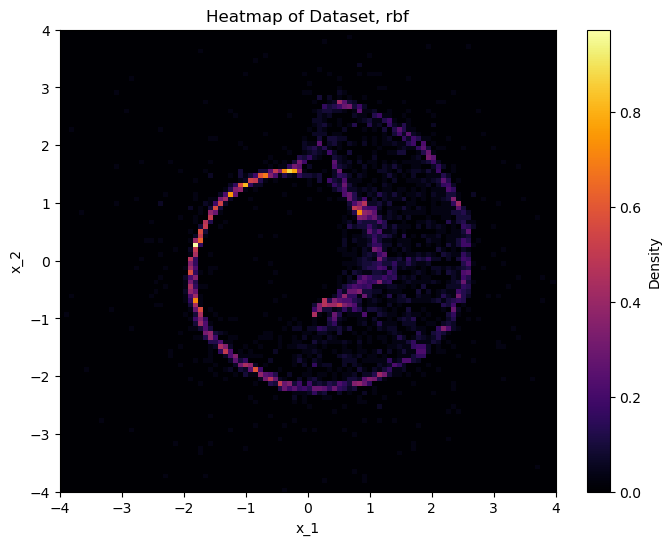

In [ ]:
param_dict = {
    'lambda': [1e-5, 3e-5],
    'bandwidth': [1e-1, 1.5e-1]
}
best_gen_rbfswiss, best_score_rbfswiss, best_loss_rbfswiss = one_model_output(ref5k, swissroll5k, rbf, param_dict, verbose=False, n_trials=5, beta=0.5, num_steps=500)
heat_map(best_gen_rbfswiss, 'rbf')

[Trial 1/5] params={'lambda': 0.00188773131310677, 'bandwidth': 0.17700108885765076} → MMD²: 0.000780
[Trial 2/5] params={'lambda': 0.0012065010659903317, 'bandwidth': 0.6767748594284058} → MMD²: 0.016457
[Trial 3/5] params={'lambda': 0.0038934761156185133, 'bandwidth': 0.5912685990333557} → MMD²: 0.004312
[Trial 4/5] params={'lambda': 0.003590664496827692, 'bandwidth': 0.4022196829319} → MMD²: 0.002138
[Trial 5/5] params={'lambda': 0.00236814475270749, 'bandwidth': 0.6473568677902222} → MMD²: 0.011828
Best config: {'lambda': 0.00236814475270749, 'bandwidth': 0.6473568677902222} | MMD²=0.000780


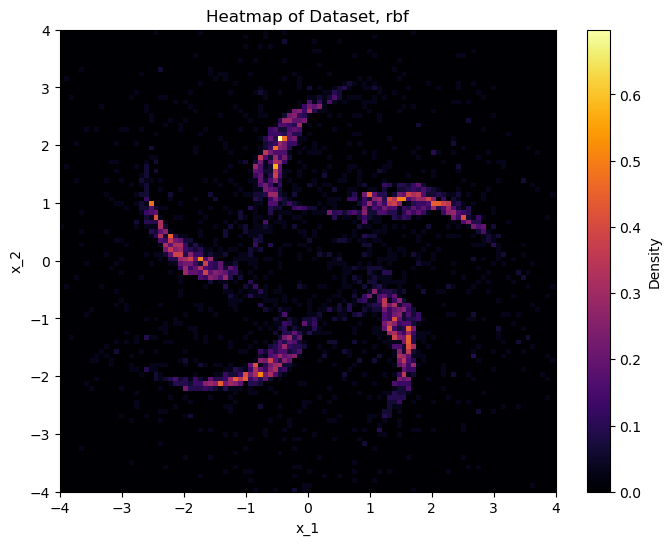

In [ ]:
param_dict = {
    'lambda': [1e-3, 1e-2],
    'bandwidth': [1e-1, 8e-1]
}
best_gen_rbfpin, best_score_rbfpin, best_loss_rbfpin = one_model_output(ref5k, pinwheel5k, rbf, param_dict, verbose=False, n_trials=5, beta=0.1, num_steps=500)
heat_map(best_gen_rbfpin, 'rbf')

[Trial 1/5] params={'lambda': 2.950776872151118e-05, 'bandwidth': 0.1320757120847702} → MMD²: 0.000051
[Trial 2/5] params={'lambda': 1.2096499766057715e-05, 'bandwidth': 0.13776704668998718} → MMD²: 0.000030
[Trial 3/5] params={'lambda': 1.686994721669567e-05, 'bandwidth': 0.10645350068807602} → MMD²: 0.000052
[Trial 4/5] params={'lambda': 1.5929069207780175e-05, 'bandwidth': 0.14573723077774048} → MMD²: 0.000033
[Trial 5/5] params={'lambda': 1.0040166905055744e-05, 'bandwidth': 0.14082171022891998} → MMD²: 0.000027
Best config: {'lambda': 1.0040166905055744e-05, 'bandwidth': 0.14082171022891998} | MMD²=0.000027


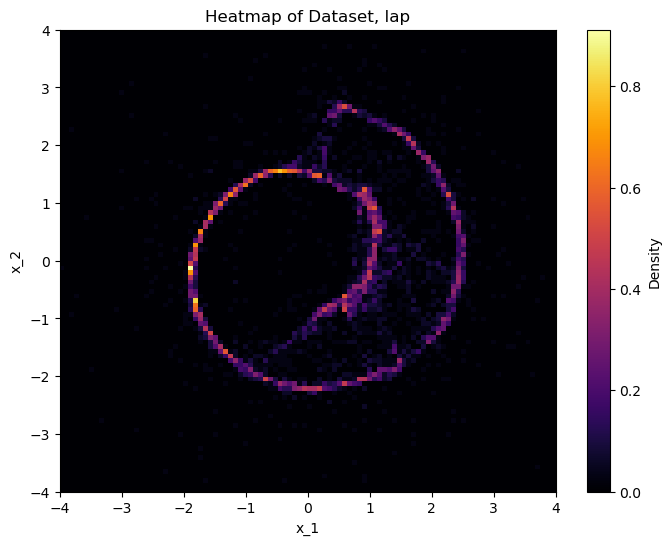

In [ ]:
param_dict = {
    'lambda': [1e-5, 3e-5],
    'bandwidth': [9e-2, 1.5e-1]
}
best_gen_lapswiss, best_score_lapswiss, best_loss_lapswiss = one_model_output(ref5k, swissroll5k, lap, param_dict, verbose=False, n_trials=5, beta=0.5, num_steps=500)
heat_map(best_gen_lapswiss, 'lap')

# pevious best bandwidth = [5e-2, 1e-1], DO NOT TOUCH lambda

[Trial 1/5] params={'lambda': 0.004722699174093526, 'bandwidth': 0.30420559644699097} → MMD²: 0.001810
[Trial 2/5] params={'lambda': 0.0022088818043964776, 'bandwidth': 0.568254292011261} → MMD²: 0.019667
[Trial 3/5] params={'lambda': 0.001585181386899123, 'bandwidth': 0.7762269973754883} → MMD²: 0.031924
[Trial 4/5] params={'lambda': 0.004558791356591792, 'bandwidth': 0.2878485918045044} → MMD²: 0.001918
[Trial 5/5] params={'lambda': 0.003268107196216095, 'bandwidth': 0.19018672406673431} → MMD²: 0.000492
Best config: {'lambda': 0.003268107196216095, 'bandwidth': 0.19018672406673431} | MMD²=0.000492


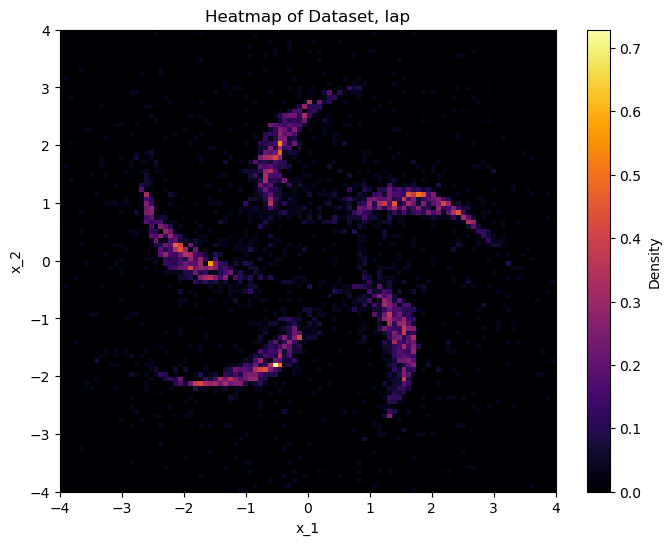

In [ ]:
param_dict = {
    'lambda': [1e-3, 1e-2],
    'bandwidth': [1e-1, 8e-1]
}
best_gen_lappin, best_score_lappin, best_loss_lappin = one_model_output(ref5k, pinwheel5k, lap, param_dict, verbose=False, n_trials=5, beta=0.1, num_steps=500)
heat_map(best_gen_lappin, 'lap')

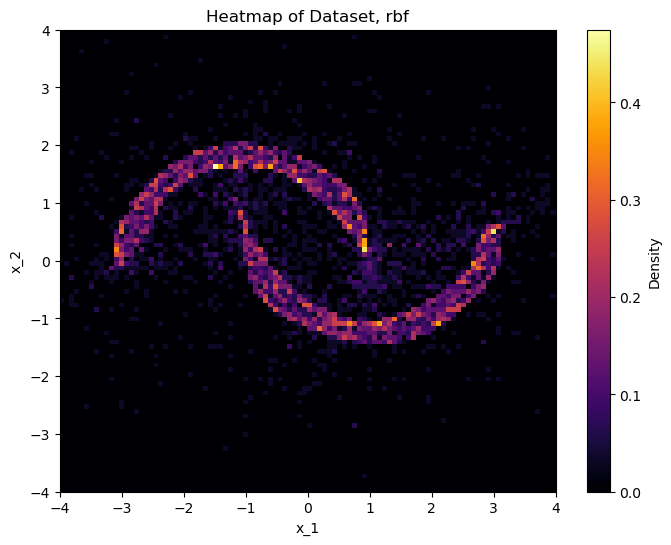

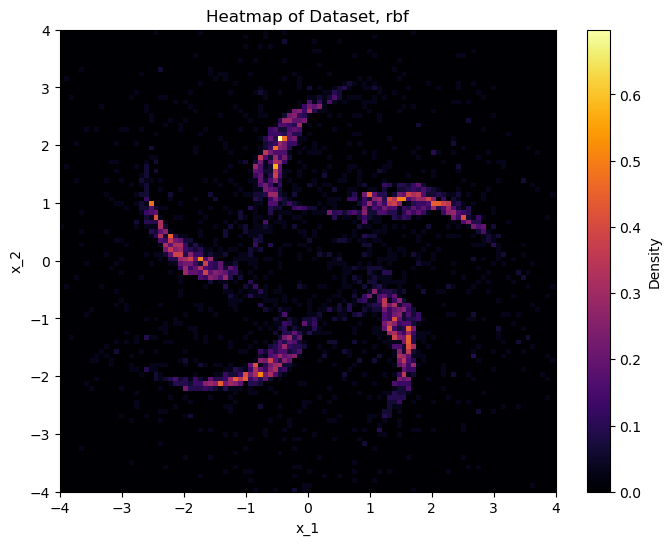

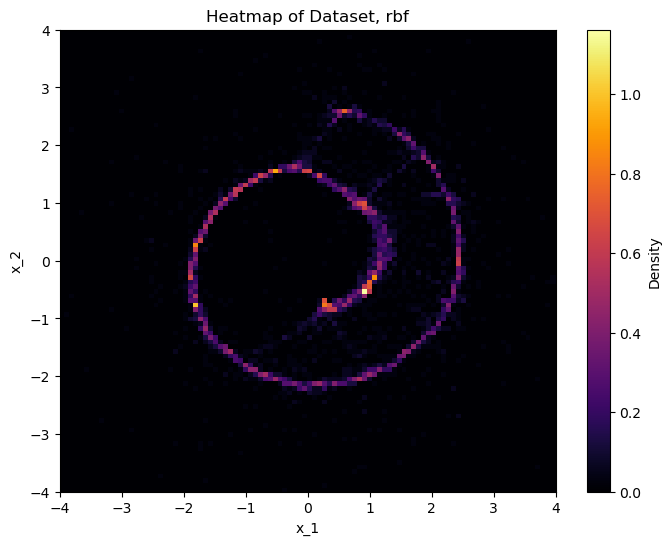

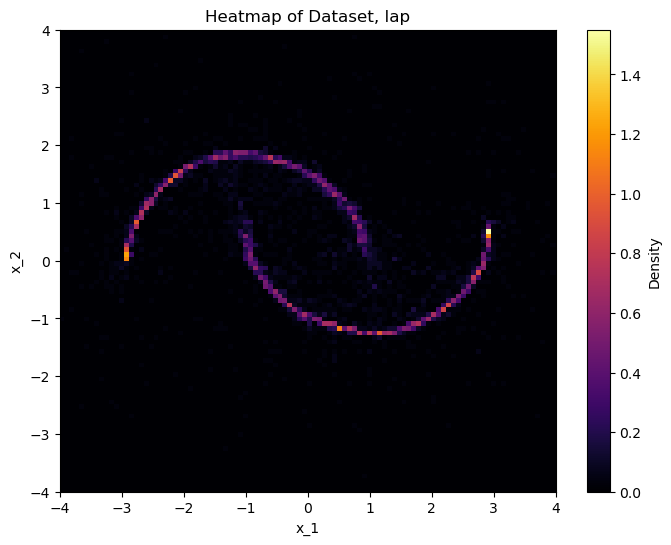

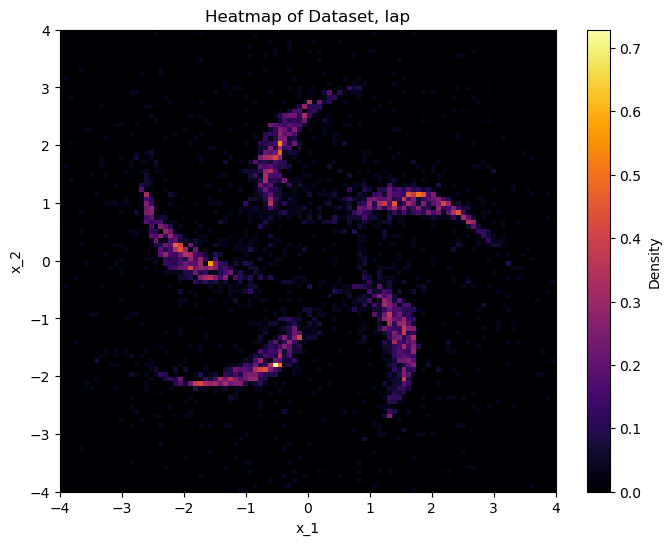

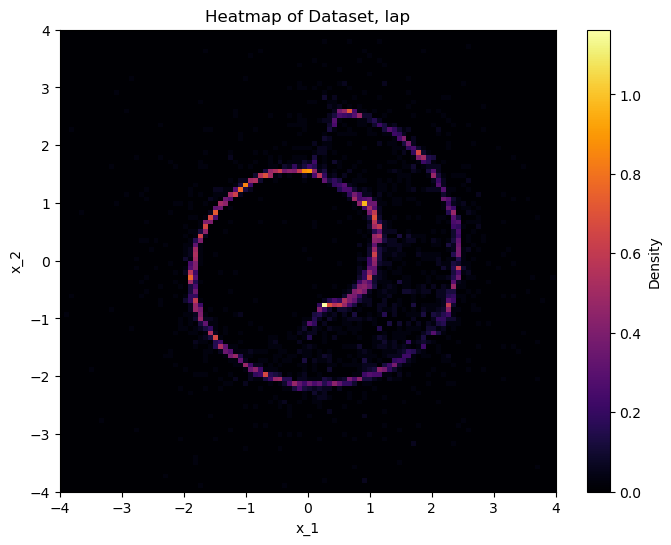

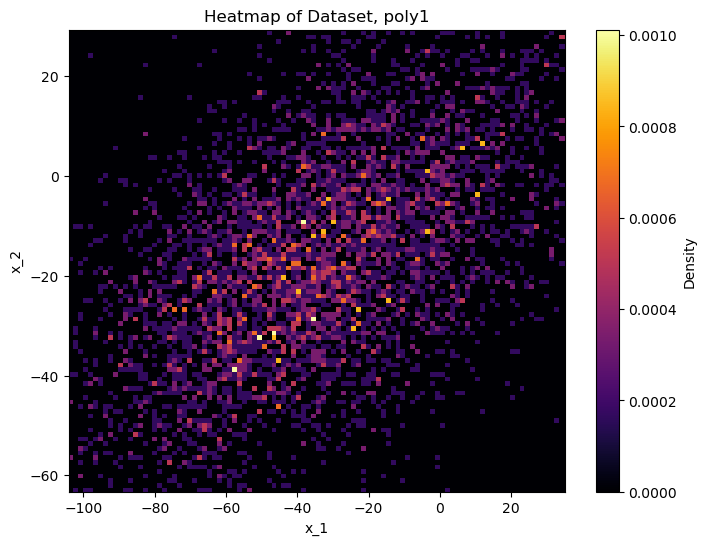

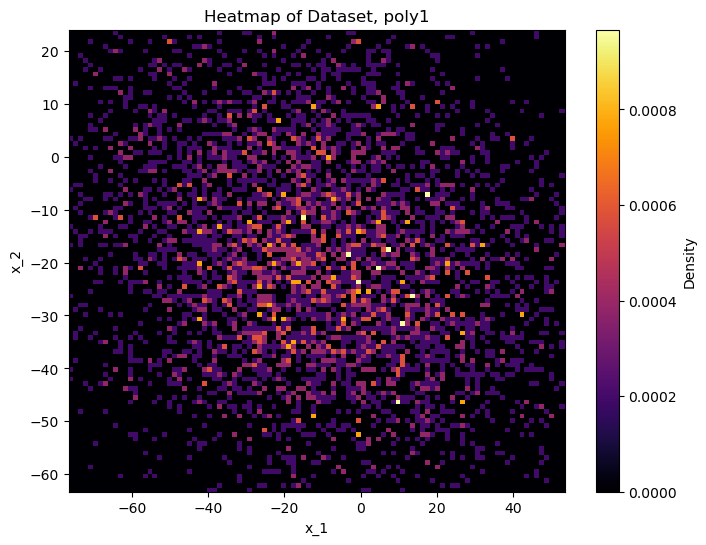

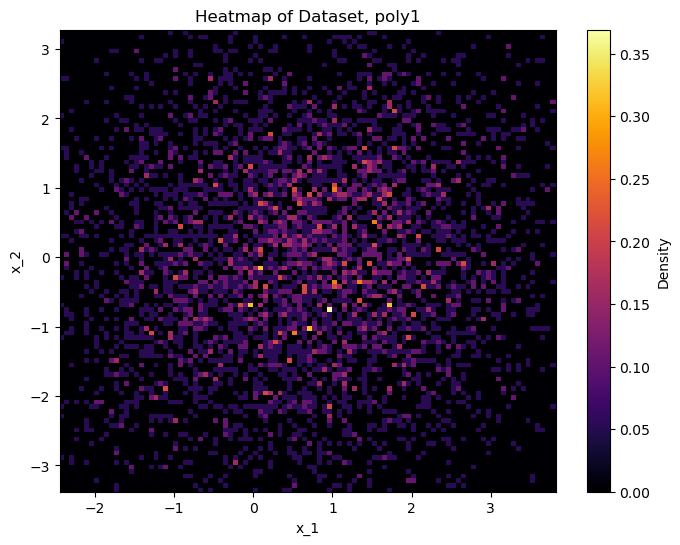

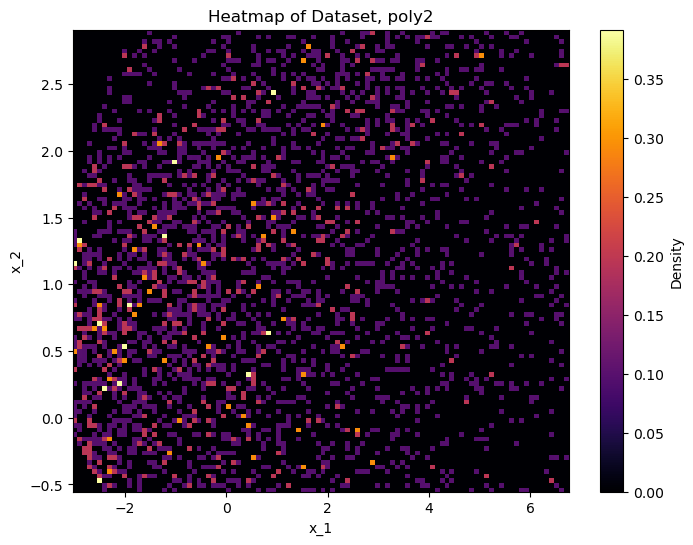

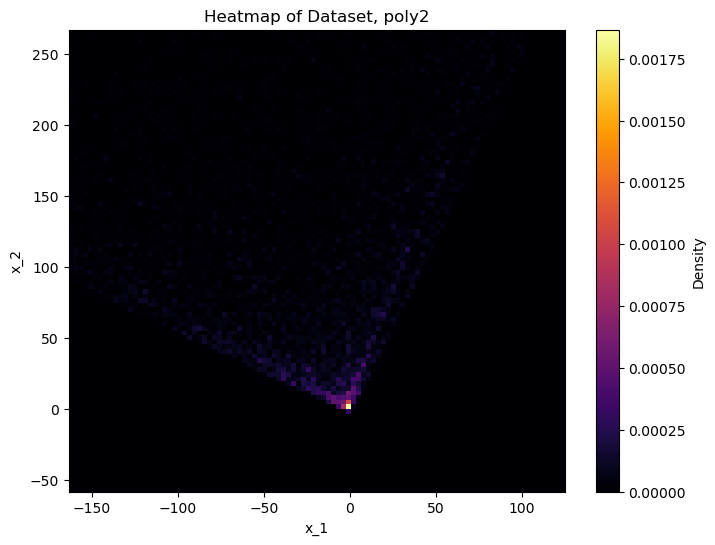

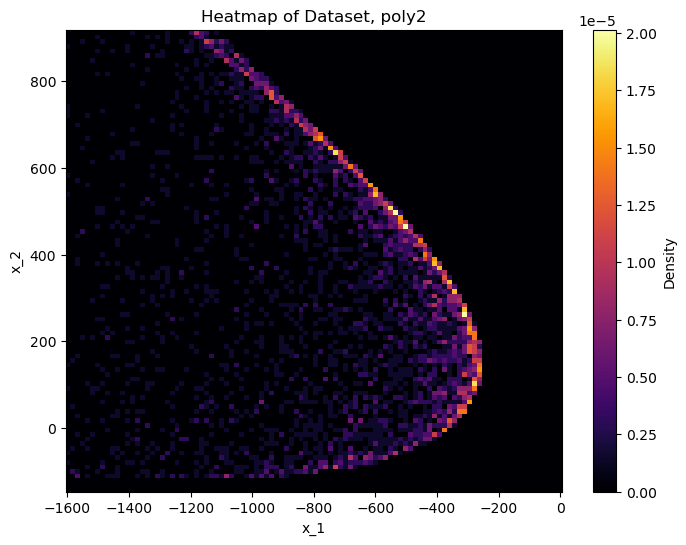

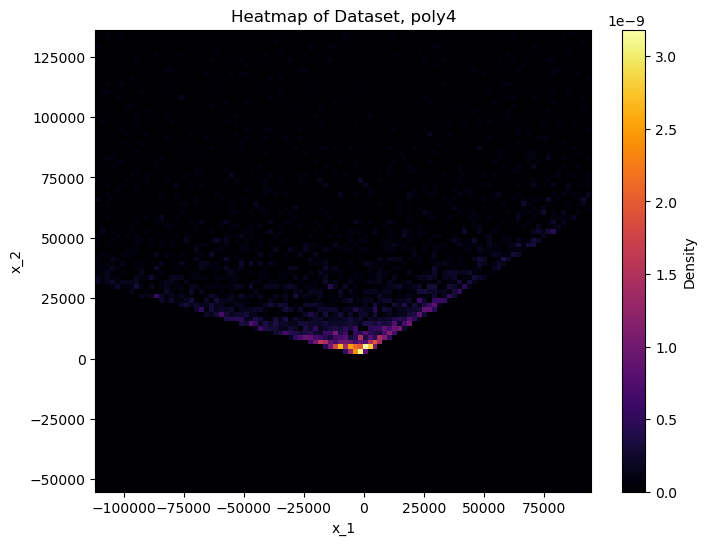

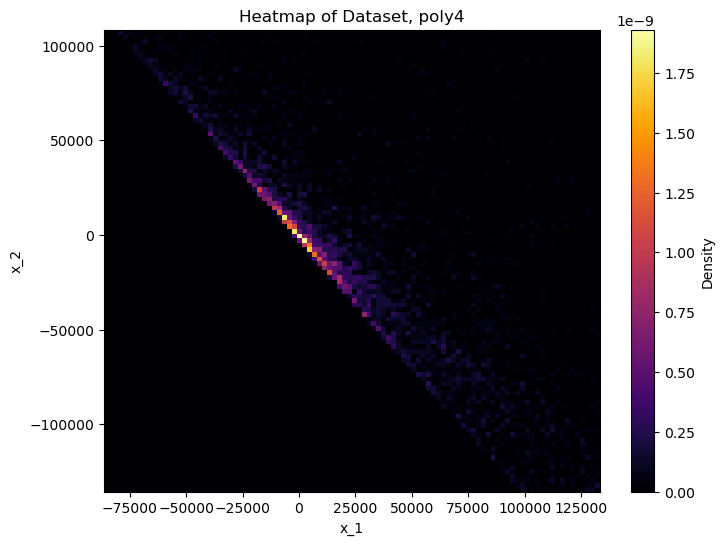

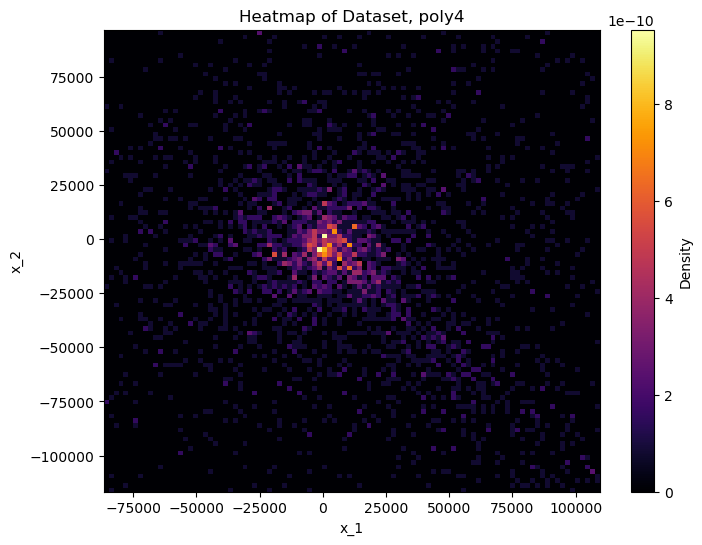

In [ ]:
best_gen_list = [best_gen_rbfmoon, best_gen_rbfpin, best_gen_rbfswiss,
                 best_gen_lapmoon, best_gen_lappin, best_gen_lapswiss,
                 best_gen_poly1moon, best_gen_poly1pin, best_gen_poly1swiss,
                 best_gen_poly2moon, best_gen_poly2pin, best_gen_poly2swiss,
                 best_gen_poly4moon, best_gen_poly4pin, best_gen_poly4swiss]
for i, best_gen in enumerate(best_gen_list):
    if i // 3 == 0:
        heat_map(best_gen, 'rbf')
    elif i // 3 == 1:
        heat_map(best_gen, 'lap')
    elif i // 3 == 2:
        heat_map(best_gen, 'poly1', std_coef=2)
    elif i // 3 == 3:
        heat_map(best_gen, 'poly2', std_coef=1)
    else:
        heat_map(best_gen, 'poly4', std_coef=0.5)

# Part 4 and beyond

In [ ]:
best_loss_list = [best_loss_rbfmoon, best_loss_rbfpin, best_loss_rbfswiss,
                 best_loss_lapmoon, best_loss_lappin, best_loss_lapswiss,
                 best_loss_poly1moon, best_loss_poly1pin, best_loss_poly1swiss,
                 best_loss_poly2moon, best_loss_poly2pin, best_loss_poly2swiss,
                 best_loss_poly4moon, best_loss_poly4pin, best_loss_poly4swiss]

best_score_list = [best_score_rbf_moon, best_score_rbfpin, best_score_rbfswiss,
                 best_score_lapmoon, best_score_lappin, best_score_lapswiss,
                 best_score_poly1moon, best_score_poly1pin, best_score_poly1swiss,
                 best_score_poly2moon, best_score_poly2pin, best_score_poly2swiss,
                 best_score_poly4moon, best_score_poly4pin, best_score_poly4swiss]

best_gen_list = [best_gen_rbfmoon, best_gen_rbfpin, best_gen_rbfswiss,
                 best_gen_lapmoon, best_gen_lappin, best_gen_lapswiss,
                 best_gen_poly1moon, best_gen_poly1pin, best_gen_poly1swiss,
                 best_gen_poly2moon, best_gen_poly2pin, best_gen_poly2swiss,
                 best_gen_poly4moon, best_gen_poly4pin, best_gen_poly4swiss]

In [ ]:
def plot_heatmaps(best_gen_list, best_score_list, kernel_names=None, std_coef=0.5):
    assert len(best_gen_list) == len(best_score_list), "Mismatched lengths"
    num_total = len(best_gen_list)
    assert num_total % 3 == 0, "List length must be divisible by 3"

    if kernel_names is None:
        # fallback names if none provided
        kernel_names = [f"Kernel {i+1}" for i in range(num_total)]

    for i in range(0, num_total, 3):
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        for j in range(3):
            idx = i + j
            ref_tran = best_gen_list[idx].cpu().numpy()
            kernel_name = kernel_names[idx]
            score = best_score_list[idx]

            x1_median = np.median(ref_tran[:, 0])
            x2_median = np.median(ref_tran[:, 1])
            x1_std = np.std(ref_tran[:, 0])
            x2_std = np.std(ref_tran[:, 1])

            if any(x in kernel_name for x in ['poly1', 'poly2', 'poly4']):
                plot_range = [
                    [x1_median - std_coef * x1_std, x1_median + std_coef * x1_std],
                    [x2_median - std_coef * x2_std, x2_median + std_coef * x2_std]
                ]
            else:
                plot_range = [[-4, 4], [-4, 4]]

            ax = axes[j]
            h = ax.hist2d(ref_tran[:, 0], ref_tran[:, 1], bins=100,
                          cmap='inferno', density=True, range=plot_range)
            fig.colorbar(h[3], ax=ax, label='Density')
            ax.set_title(f"{kernel_name}\nScore = {score:.6f}")
            ax.set_xlabel('x₁')
            ax.set_ylabel('x₂')

        plt.tight_layout()
        plt.savefig(f"figure{i//3 + 3}.png", format='png', bbox_inches='tight')
        plt.show()

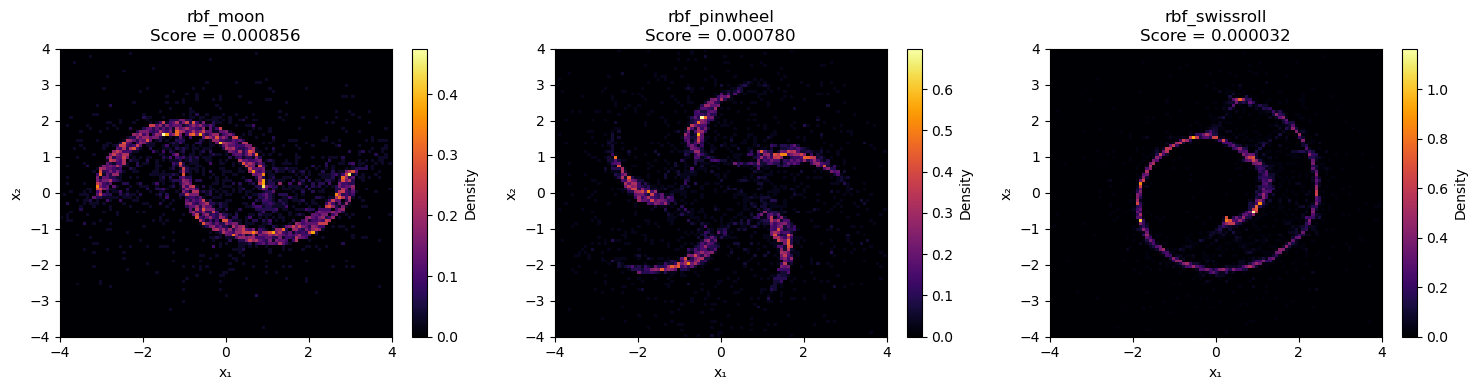

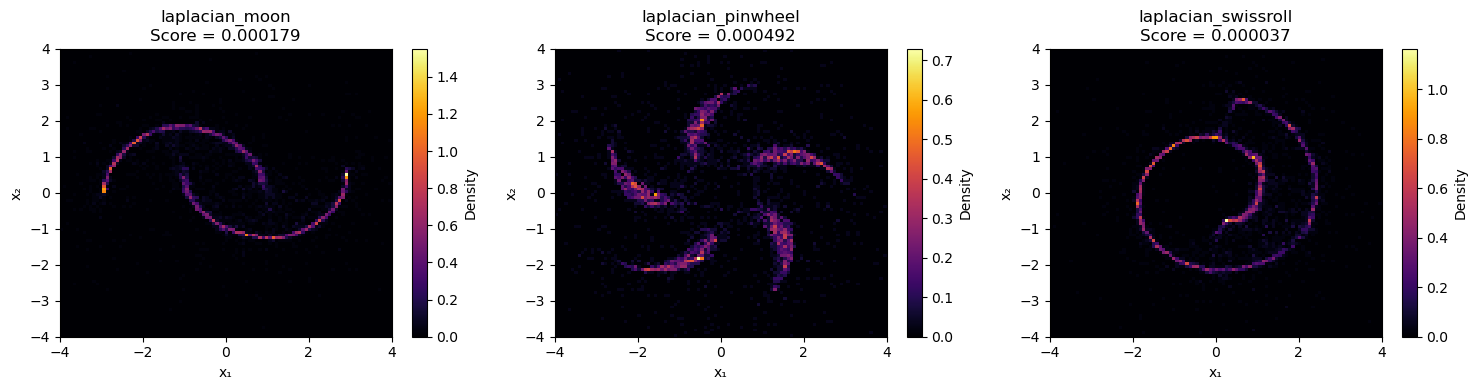

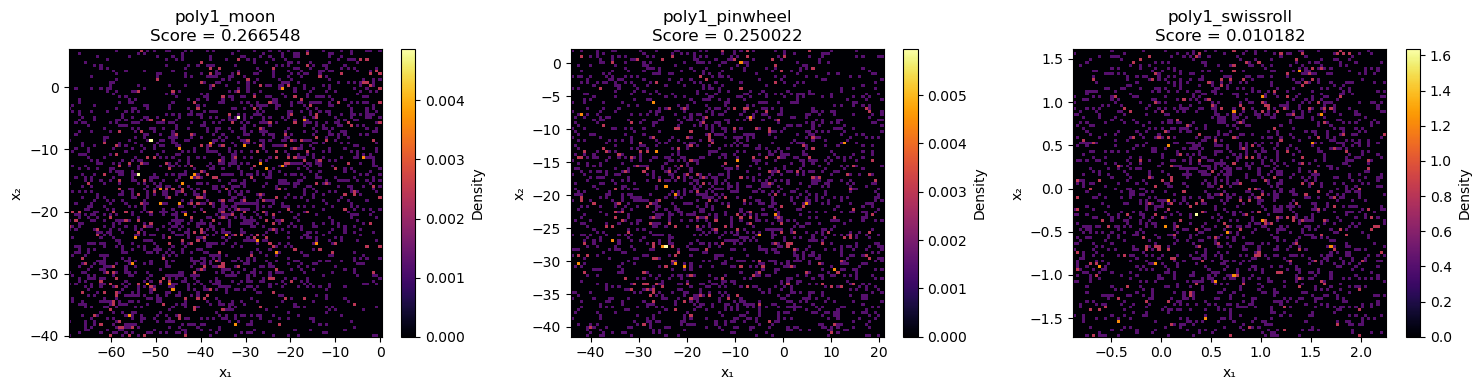

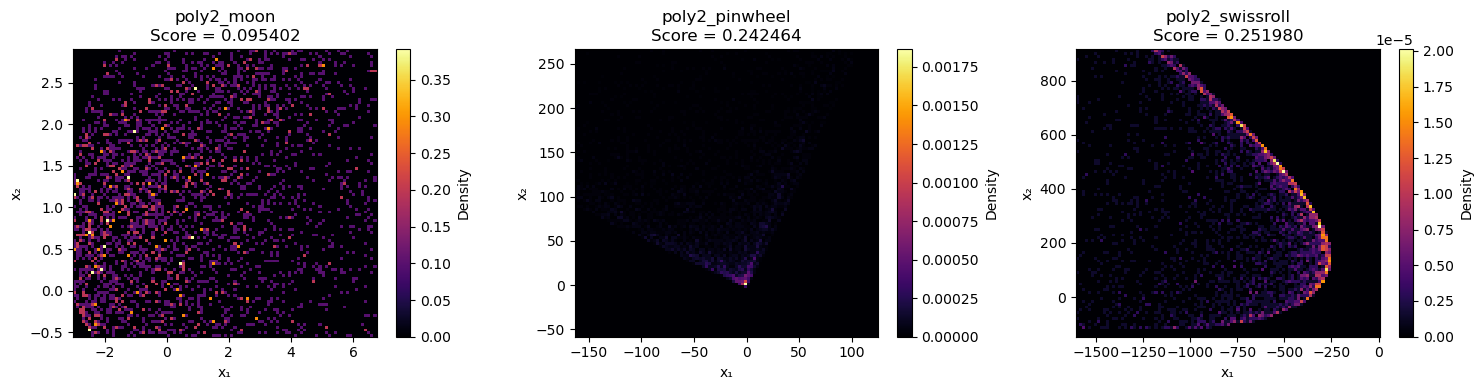

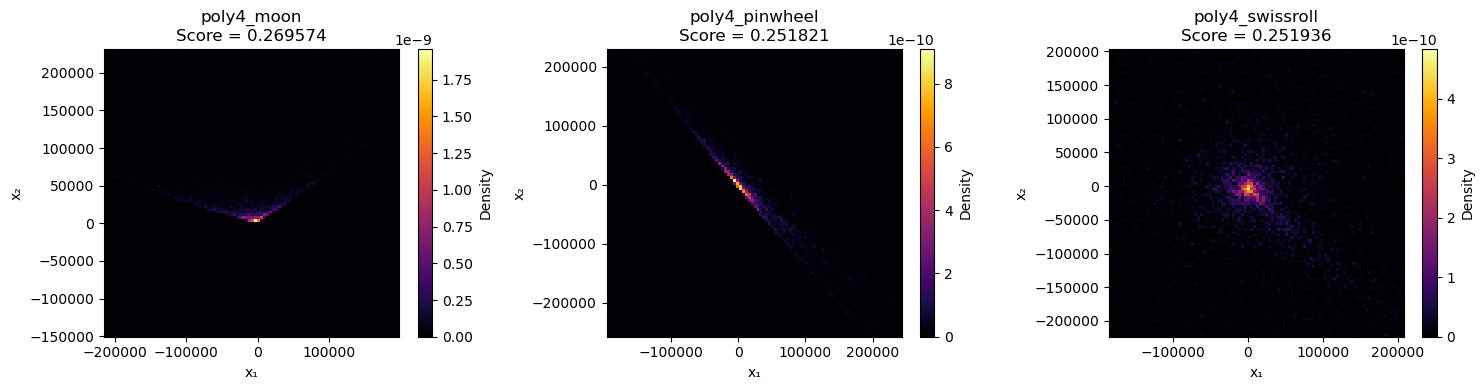

In [ ]:
kernel_names = [
    "rbf_moon", "rbf_pinwheel", "rbf_swissroll",
    "laplacian_moon", "laplacian_pinwheel", "laplacian_swissroll",
    "poly1_moon", "poly1_pinwheel", "poly1_swissroll",
    "poly2_moon", "poly2_pinwheel", "poly2_swissroll",
    "poly4_moon", "poly4_pinwheel", "poly4_swissroll"
]

plot_heatmaps(best_gen_list, best_score_list, kernel_names, std_coef=1.0)

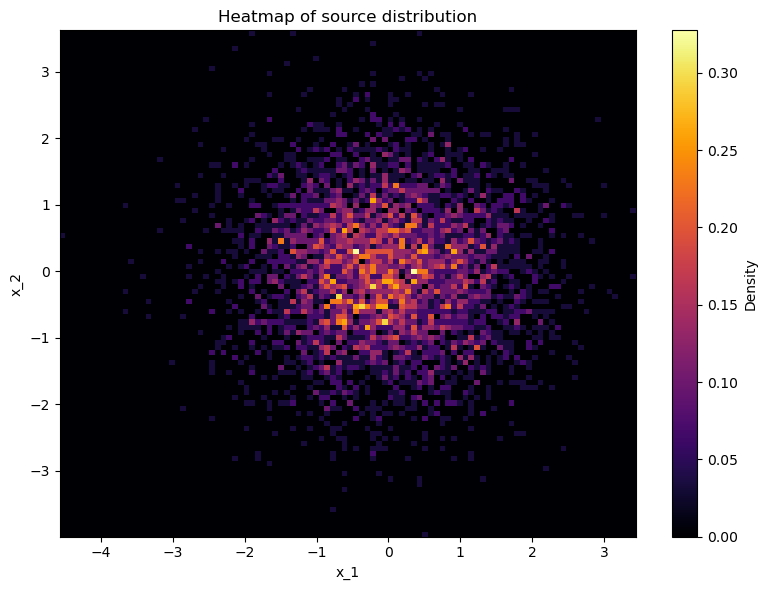

In [ ]:
ref5k_plot = ref5k.detach().cpu().numpy()
plt.figure(figsize=(8, 6))
plt.hist2d(ref5k_plot[:, 0], ref5k_plot[:, 1], bins=100, cmap='inferno', density=True)
plt.colorbar(label='Density')
plt.title('Heatmap of source distribution')
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.tight_layout()
plt.savefig('figure1.pdf')
plt.show()

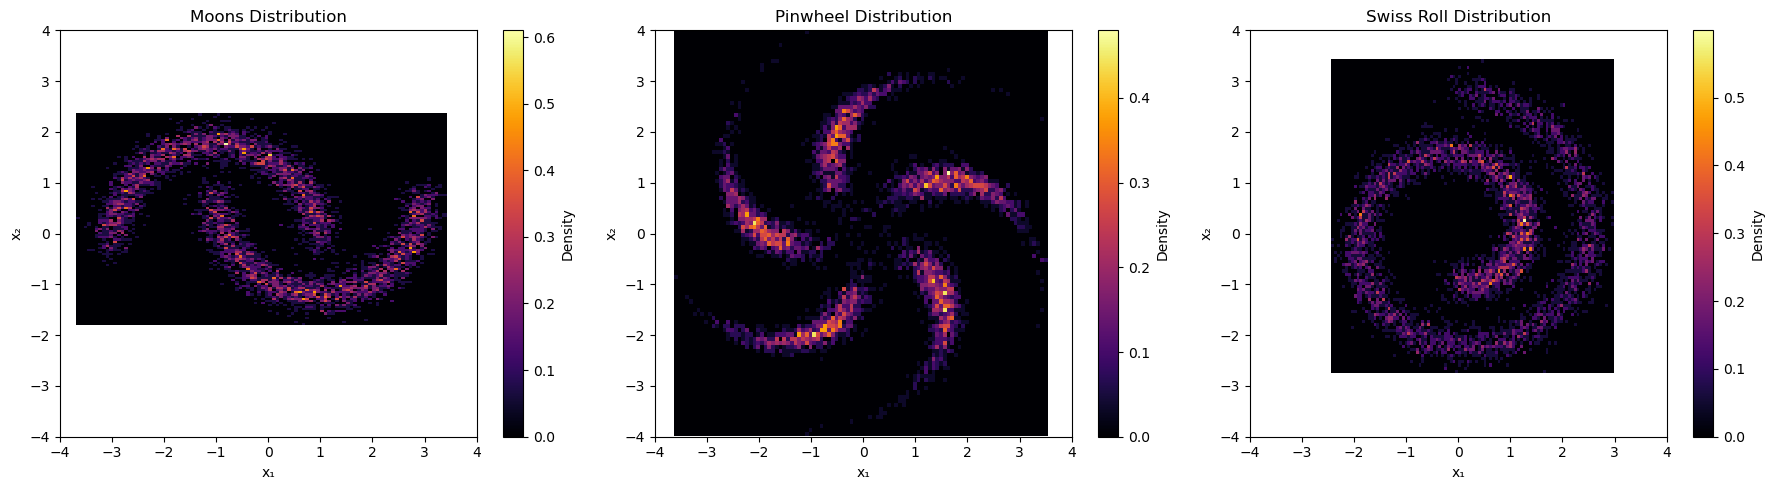

In [ ]:
datasets = {
    'Moons': moons5k,
    'Pinwheel': pinwheel5k,
    'Swiss Roll': swissroll5k
}

plt.figure(figsize=(18, 5))  # 3 subplots in a row

for i, (name, data_tensor) in enumerate(datasets.items(), 1):
    data_np = data_tensor.detach().cpu().numpy()
    plt.subplot(1, 3, i)
    plt.hist2d(data_np[:, 0], data_np[:, 1], bins=100, cmap='inferno', density=True)
    plt.colorbar(label='Density')
    plt.title(f'{name} Distribution')
    plt.xlabel('x₁')
    plt.ylabel('x₂')
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)

plt.tight_layout()
plt.savefig('figure2.pdf')
plt.show()

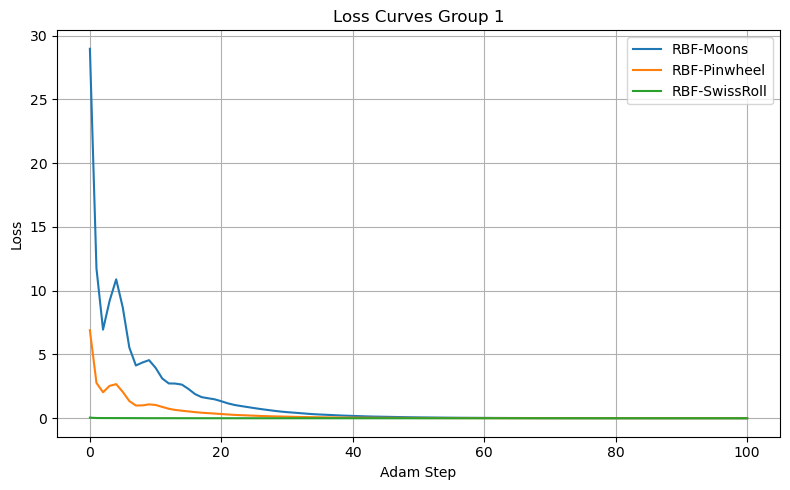

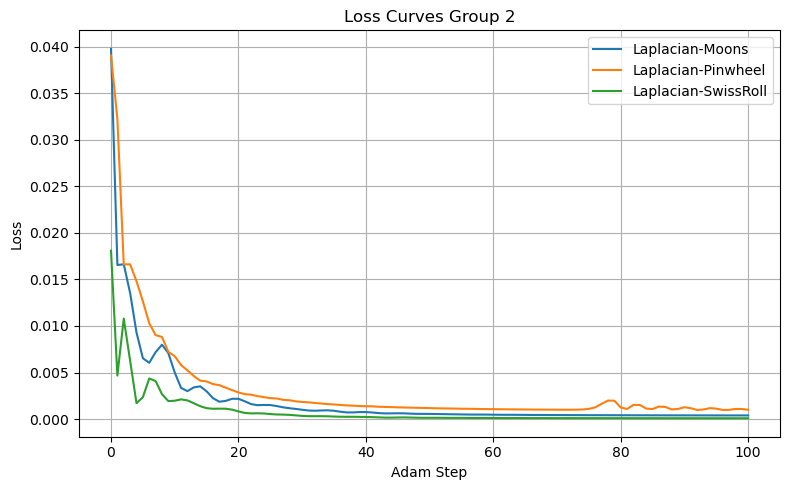

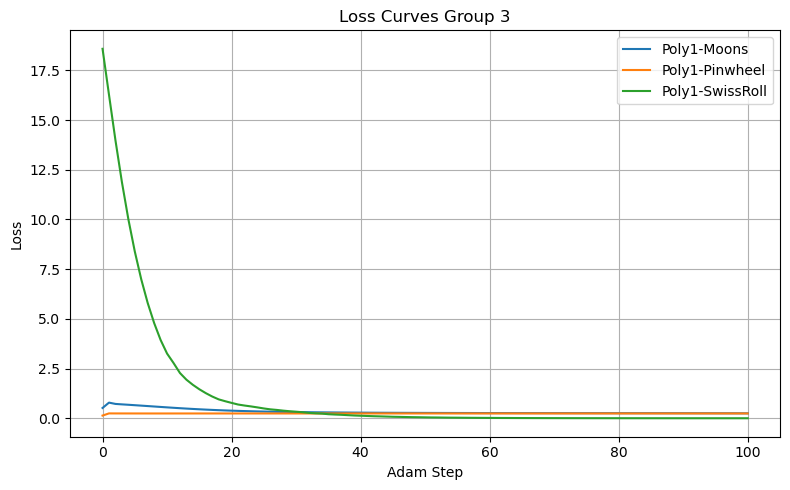

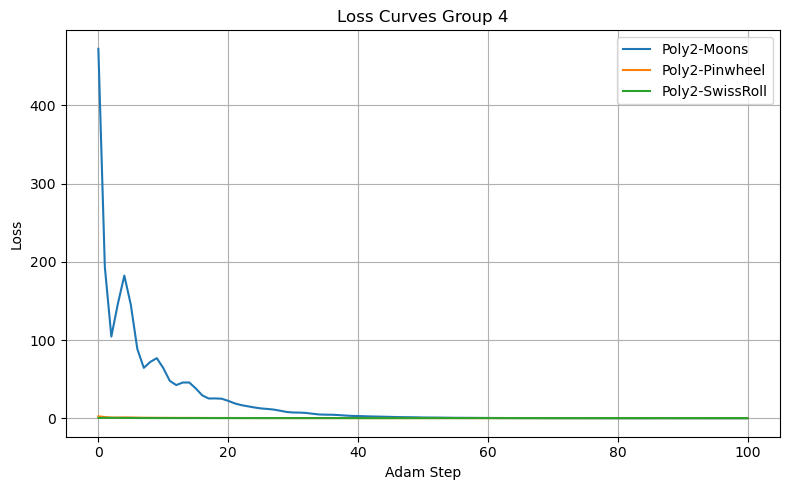

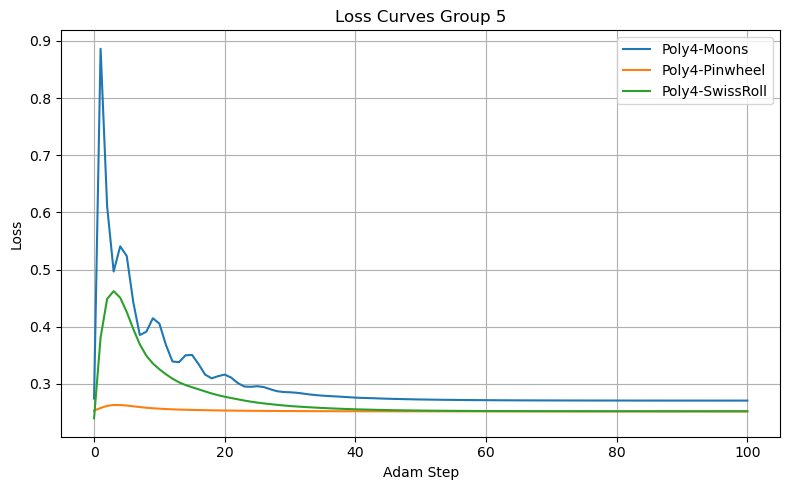

In [ ]:
steps = np.arange(500)

group_labels = [
    ['RBF-Moons', 'RBF-Pinwheel', 'RBF-SwissRoll'],
    ['Laplacian-Moons', 'Laplacian-Pinwheel', 'Laplacian-SwissRoll'],
    ['Poly1-Moons', 'Poly1-Pinwheel', 'Poly1-SwissRoll'],
    ['Poly2-Moons', 'Poly2-Pinwheel', 'Poly2-SwissRoll'],
    ['Poly4-Moons', 'Poly4-Pinwheel', 'Poly4-SwissRoll']
]

for i in range(0, len(best_loss_list), 3):
    plt.figure(figsize=(8, 5))
    for j in range(3):
        # Convert list of tensors to 1D NumPy array
        tensor_list = best_loss_list[i + j]
        loss_curve = np.array([x.detach().cpu().item() for x in tensor_list])
        label = group_labels[i // 3][j]
        plt.plot(steps[0:101], loss_curve[0:101], label=label)

    plt.title(f"Loss Curves Group {i // 3 + 1}")
    plt.xlabel("Adam Step")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"figure{i // 3 + 8}.pdf")
    plt.show()